In [124]:
import tensorflow as tf
import numpy as np
import re
import os
from dataset import DataSet
import pandas as pd
import matplotlib.pyplot as plt

class auto_coding():
    
    def __init__(self, new_code, model_name, batch_size=50, epochs=100, patience=10, verbose=1, model_summary=False, model_save=False, model_load=False, data_split=False, data_split_num=5, model_load_only=False):
        
        tf.random.set_seed(42)
        
        # get data
        self.data_ = DataSet(new_code=new_code)
        self.x, self.y, self.max_word_len, self.vocab_size = self.data_.get_dataset()
        self.word2idx, self.idx2word = self.data_.make_word2idx_idx2word(get_vocab_size=False)
        self.y_pred = None
        self.verbose = verbose
        
        # model parameters
        self.new_code = new_code + ' ' + ' '.join(['tuple', 'list', 'dic', 'return', 'print', 
                         'for', 'range', 'while', 'not', 'is', 'sort'])
        self.filepath = f"{model_name}/best.hdf5"
        self.model_summary = model_summary
        self.verbose = verbose
        self.batch_size = batch_size
        self.model_save = model_save
        self.model_load = model_load
        self.model_name = model_name
        self.EPOCHS = epochs
        self.patience = patience
        self.data_split = data_split
        self.data_split_num = data_split_num
        
        if model_load_only:
            self.model = tf.keras.models.load_model(f'{self.model_name}/{self.model_name}.h5')
            self.model.load_weights(self.filepath)
            
        else:
            if self.data_split:
                self.total_xys = self.split_data(num=self.data_split_num)

                for x, y in self.total_xys:
                    self.train_model(x, y)
            else:
                self.train_model(self.x, self.y)
        
    def train_model(self, x, y):
        # model compiling
        ## if model_load=True, load the model from a directory specified as model_name
        if self.model_load:
            try:
                self.model = tf.keras.models.load_model(f'{self.model_name}/{self.model_name}.h5')
                print(f">>> Load {self.model_name} over your model!")
            except OSError:
                self.model = self.gru_lstm_model()
                print(f">>> Failed to load {self.model_name}. \n>>>Load base model instead!")
        else:
            self.model = self.gru_lstm_model()
            print("Build a new model before starting your training!")
        
        # mode whether to show the summary or not
        if self.model_summary:
            print(self.model.summary())
            
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'], run_eagerly=True)
        
        # callback parameters
        self.callback = tf.keras.callbacks.EarlyStopping(monitor='acc', patience=self.patience)
        os.makedirs(self.model_name, exist_ok=True)
        self.model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=self.filepath,
                                                                           save_weights_only=True,
                                                                           save_best_only=True,
                                                                           monitor='acc', 
                                                                           save_freq='epoch')
        
        # train model
        print("==== TRAINING START ====")
        self.history = self.model.fit(x, y, 
                                      batch_size = self.batch_size,
                                      verbose = self.verbose,
                                      epochs=self.EPOCHS, 
                                      callbacks=[self.callback, 
                                                 self.model_checkpoint_callback]
                                      )
        print("==== TRAINING DONE ====")
        
        print("Now, Load the best weights on your model.")
        self.model.load_weights(self.filepath)
        
        # if model-save mode, save the current trained model
        if self.model_save:
            os.makedirs(self.model_name, exist_ok=True)
            self.model.save(f'{self.model_name}/{self.model_name}.h5')
            print(f">>> Saved this trained model over {self.model_name}.h5 file!")
            
    def gru_lstm_model(self):
        inputs = tf.keras.layers.Input(shape=(self.max_word_len,))
        embedding = tf.keras.layers.Embedding(self.vocab_size, 500, input_length=self.max_word_len)(inputs) # (None, max_word_len, 500)
        x = tf.keras.layers.GRU(512)(embedding)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        
        x1 = tf.keras.layers.LSTM(512)(embedding)
        x1 = tf.keras.layers.Dense(256, activation='relu')(x1)
        
        x = tf.keras.layers.concatenate([x, x1], axis=1)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        
        outputs = tf.keras.layers.Dense(self.vocab_size, activation='softmax')(x) # (None, length of word dictionary)
        return tf.keras.models.Model(inputs=inputs, outputs=outputs)
    
    # return unregistered word input to '[UKN]' token to prevent KeyError/IndexError
    def word2idx_get(self, char):
        if self.word2idx.get(char) == None:
            return self.word2idx.get('[UKN]')
        else:
            return self.word2idx.get(char)
           
    def vec2word(self, x):
        x_ = []
        for word in x:
            word_temp = ''
            for char in word:
                if char != 0:
                    word_temp += self.idx2word.get(char)
            x_.append(word_temp)
        return x_
    
    # predict the user's choice
    def return_pred(self, test):
        assert type(test) == list
        test_vec = [[self.word2idx_get(char) for char in word] for word in test]
        x_test = tf.keras.preprocessing.sequence.pad_sequences(test_vec, maxlen=self.max_word_len, padding='pre')
        self.y_pred = self.model.predict(x_test)

    # get all possible words with over 0.027 softmax values
    def predict_recommendations(self):
        best_preds = self.predict_best()
        result_arr = np.argwhere(self.y_pred>0.027)
        result = []
        for pred_idx in range(len(self.y_pred)):
            temp_ls = []
            for i in range(len(result_arr)):
                if pred_idx == result_arr[i, 0]:
                    temp_ls.append(result_arr[i, -1])
            result.append(temp_ls)

        return [[self.idx2word.get(idx) for idx in pred] for pred in result]

    # predict the most promising following word from given word fragments
    def predict_best(self):
        """return the list of best suited words"""
        pred = [np.argmax(result) for result in self.y_pred]
        return [self.idx2word.get(idx) for idx in pred]

    # display the result of recommended auto-completions
    def auto_complete(self, test, display_result=True):
        """print matches of given word and recommended auto completion"""
        if type(test) == str:
            test = [test]
        self.return_pred(test)
        best_preds = self.predict_best()
        recc_preds = self.predict_recommendations()
        
        self.results = []
        self.best_results = []
        for i in range(len(test)):
            self.results.append([test[i]+candidate for candidate in recc_preds[i]])
            self.best_results.append(test[i]+best_preds[i])
            if display_result:
                print(test[i], ' - best match :', test[i]+best_preds[i])
                print('\t - all recommendations : ', [test[i]+candidate for candidate in recc_preds[i]])
                
        # calculate AFR : Accuracy for Recommendations
        bow = self.word2idx.keys()
        
        self.acc = sum([pred in self.new_code for pred in self.best_results])/len(self.best_results)
        print('Accuracy for Best: ', self.acc)
        
        tot_preds = [pred for preds in self.results for pred in preds]
        n_true = 0
        for pred in tot_preds:
            if pred in self.new_code:
                n_true += 1
        try:
            self.afr = n_true/len(tot_preds)
        except ZeroDivisionError:
            self.afr = 0.0
        print('Accuracy for Recommendations : ', self.afr)
                
    def plot_history(self):
        hist = pd.DataFrame(self.history.history)
        hist['epoch'] = self.history.epoch

        plt.figure(figsize=(8,7))

        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.plot(hist['epoch'], hist['acc'],
               label='Train Error')
        plt.plot(hist['epoch'], hist['loss'],
               label = 'Train Loss')
        plt.ylim([0,1])
        plt.legend()
        plt.grid()
        plt.show()
    
    # in case of training big data, this is to split the data into the designated number
    def split_data(self, num=10):
        total_length = len(self.x)
        total_xys = []
        for i in range(num):
            globals()[f'x_{i}'] = self.x[int(total_length*(1/num))*i:int(total_length*(1/num))*(i+1)]
            globals()[f'y_{i}'] = self.y[int(total_length*(1/num))*i:int(total_length*(1/num))*(i+1)]
            total_xys.append((globals()[f'x_{i}'], globals()[f'y_{i}']))
        return total_xys

In [125]:
samp_text = """import tensorflow as tf
import numpy as np
import re
import os
from dataset import DataSet
import pandas as pd
import matplotlib.pyplot as plt
"""

In [128]:
samp_model = auto_coding(new_code=samp_text,
                      # verbose=0,
                       model_summary=True,
                       model_save=True,
                       model_name='samp_test',
                       model_load=True,
                      )

>>> Failed to load samp_test. 
>>>Load base model instead!
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 17)]         0           []                               
                                                                                                  
 embedding_20 (Embedding)       (None, 17, 500)      85000       ['input_21[0][0]']               
                                                                                                  
 gru_21 (GRU)                   (None, 512)          1557504     ['embedding_20[0][0]']           
                                                                                                  
 lstm_25 (LSTM)                 (None, 512)          2074624     ['embedding_20[0][0]']           
                                

In [129]:
x_test = ['t', 'tup', 'p', 'li', 'd', 'I', 'so', 'm']

samp_model.auto_complete(x_test)

t  - best match : tf
	 - all recommendations :  ['tensorflow', 'tf']
tup  - best match : tuple
	 - all recommendations :  []
p  - best match : pd
	 - all recommendations :  ['plt', 'pd', 'pandas']
li  - best match : list
	 - all recommendations :  []
d  - best match : dataset
	 - all recommendations :  ['dic', 'dataset']
I  - best match : Import
	 - all recommendations :  []
so  - best match : sort
	 - all recommendations :  ['sort']
m  - best match : matplotlib.pyplot
	 - all recommendations :  []
Accuracy for Best:  0.875
Accuracy for Recommendations :  1.0


In [5]:
tf_filepath = "../data/text_data/tf_all_symbols.txt"
with open(tf_filepath, 'r') as f:
    tf_code_text = f.read()
    
my_model = auto_coding(new_code=tf_code_text,
                      # verbose=0,
                       batch_size=100,
                       epochs=200,
                       patience=12,
                       model_summary=True,
                       model_save=True,
                       model_name='tf_model',
                       model_load=True,
                       data_split=True,
                       data_split_num=10
                      )


>>> Failed to load tf_model. 
>>>Load base model instead!
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 66)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 66, 500)      60962000    ['input_2[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 512)          1557504     ['embedding_1[0][0]']            
                                                                                                  
 lstm_1 (LSTM)                  (None, 512)          2074624     ['embedding_1[0][0]']            
                                  

In [6]:
x_test = ['t', 'tup', 'p', 'li', 'd', 'In', 'so', 'k', 'tf.', 'Embe', 'L', 'act', ]

my_model.auto_complete(x_test)

t  - best recommendation : tf
		 - all recommendations :  ['test', 'train', 'tpu', 'tf']
tup  - best recommendation : tuple
		 - all recommendations :  ['tupe', 'tuple']
p  - best recommendation : parse
		 - all recommendations :  ['pace_to_batch_nd', 'plit', 'parse', 'pu']
li  - best recommendation : list_variables
		 - all recommendations :  ['list_variables', 'linear_to_mel_weight_matrix']
d  - best recommendation : difference
		 - all recommendations :  ['disable_with_predicate', 'difference', 'dct']
In  - best recommendation : Int64List
		 - all recommendations :  ['Int64List']
so  - best recommendation : softmax
		 - all recommendations :  ['softsign', 'softmax', 'sort']
k  - best recommendation : kaiser_window
		 - all recommendations :  ['kaiser_window', 'kaiser_bessel_derived_window']
tf.  - best recommendation : tf.dct
		 - all recommendations :  ['tf.dct', 'tf.est', 'tf.ft', 'tf.fft', 'tf.rfft2d', 'tf.ile', 'tf.fft3d', 'tf.obDef']
Embe  - best recommendation : Embedding
		 -

In [7]:
my_model.results

[['test', 'train', 'tpu', 'tf'],
 ['tupe', 'tuple'],
 ['pace_to_batch_nd', 'plit', 'parse', 'pu'],
 ['list_variables', 'linear_to_mel_weight_matrix'],
 ['disable_with_predicate', 'difference', 'dct'],
 ['Int64List'],
 ['softsign', 'softmax', 'sort'],
 ['kaiser_window', 'kaiser_bessel_derived_window'],
 ['tf.dct',
  'tf.est',
  'tf.ft',
  'tf.fft',
  'tf.rfft2d',
  'tf.ile',
  'tf.fft3d',
  'tf.obDef'],
 ['Embedding', 'EmbeddingGradients', 'Embeedding', 'Embect'],
 ['LossScale', 'LoadOptions'],
 ['acturate_cast', 'actter_nd', 'acts']]

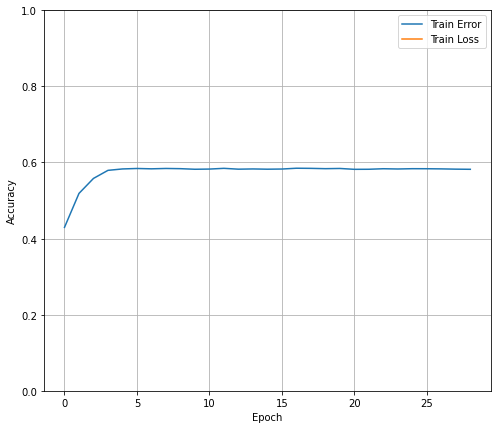

In [8]:
my_model.plot_history()